# COVID-Team-1

## Dr. Mohanty

## Katelynn Urgitus

## CSC 405-01

## Last Updated: 11/14/2020

## I, Katelynn Urgitus, have abided by the UNCG Academic Integrity Policy.

# ----------------------------------------------------------------------------------------------------------------

In this notebook I will:

Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties,

Identify which counties are most at risk,

Utilize the hospital data to calculate the point of no return for a state,

Utilize decision tree, random forest, and ARIMA based models to compare and contrast the performance of each,

Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county.

# ----------------------------------------------------------------------------------------------------------------

In [1]:
import os 
os.chdir("../")

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

### Data Paths

In [3]:
daily_penn_cases_normalized = "../data/Covid/Kat/Pennsylvania/daily_Penn_cases_normalized.csv"
cases_full = pd.read_csv(daily_penn_cases_normalized)
cases_only = cases_full.iloc[:, 1:]
cases_only = cases_only.sum()
cases_only_new = cases_only.astype('int') 
new_cases = cases_only_new
daily_penn_deaths_normalized = "../data/Covid/Kat/Pennsylvania/daily_Penn_deaths_normalized.csv"
deaths_full = pd.read_csv(daily_penn_deaths_normalized)
deaths_only = deaths_full.iloc[:, 1:]
deaths_only = deaths_only.sum()
deaths_only_new = deaths_only.astype('int')  
new_deaths = deaths_only_new
hospital_data = "../data/Hospitals/hospital_merged_covid_penn.csv"
arima_data = "../data/Covid/Kat/Pennsylvania/penn_daily_cases_arima.csv"

## Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties

In [4]:
display(new_cases)
display(new_deaths)

1/22/2020        0
1/23/2020        0
1/24/2020        0
1/25/2020        0
1/26/2020        0
              ... 
11/7/2020     2057
11/8/2020     1613
11/9/2020     1607
11/10/2020    2332
11/11/2020    2537
Length: 295, dtype: int32

1/22/2020      0
1/23/2020      0
1/24/2020      0
1/25/2020      0
1/26/2020      0
              ..
11/7/2020     32
11/8/2020      1
11/9/2020      1
11/10/2020    51
11/11/2020    37
Length: 295, dtype: int32

In [5]:
days_since_first_case = []
i = 0
for x in new_cases.index:
    days_since_first_case += [i]
    i+=1

#### Cases

In [6]:
arr = np.asarray(days_since_first_case)
reshaped_days_since_first = arr.reshape(-1,1)
X = reshaped_days_since_first
Y = new_cases.values.reshape(-1, 1)

In [7]:
regressor = LinearRegression()
regressor.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
y_pred = regressor.predict(X)

In [9]:
print(regressor.coef_)
print(regressor.intercept_)

[[3.07474548]]
[-118.29267064]


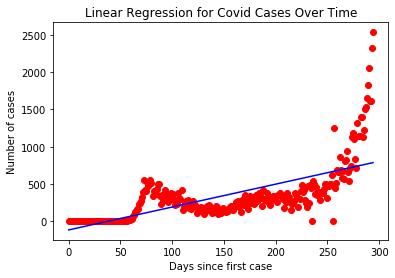

In [10]:
plt.scatter(X,Y,color = 'red')
plt.plot(X,y_pred,color = 'blue')
plt.title('Linear Regression for Covid Cases Over Time')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

In [11]:
r2_score(Y,y_pred)

0.4670277405280845

##### Decision Tree

In [12]:
# Here I go ahead and use the decision tree for a later analysis
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X,Y)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("penn_cases") 

'penn_cases.pdf'

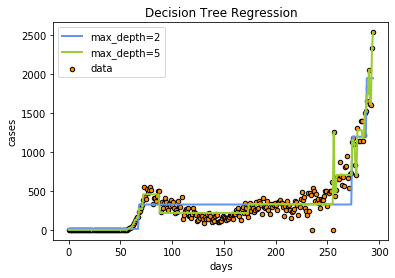

In [13]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, Y)
regr_2.fit(X, Y)
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
plt.figure()
plt.scatter(X, Y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("days")
plt.ylabel("cases")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

##### Random Forest

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=200, test_size=95, random_state=4)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

C:\Users\katel\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


IndexError: too many indices for array

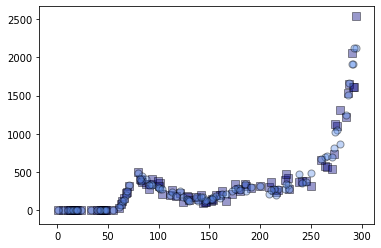

In [15]:
plt.figure()
s = 50
a = 0.4
plt.scatter(X_test, y_test[:, 0], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(X_test, y_multirf[:, 0], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:,0],y_rf[:,1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

##### ARIMA

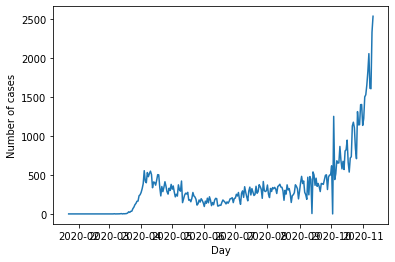

In [16]:
penn_df = pd.read_csv(arima_data, parse_dates = ['Day'], index_col = ['Day'])
plt.xlabel('Day')
plt.ylabel('Number of cases')
plt.plot(penn_df)

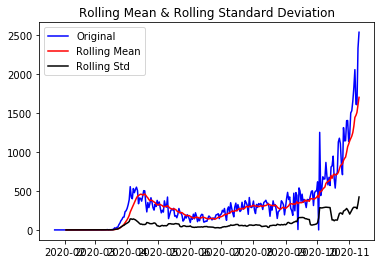

In [17]:
rolling_mean = penn_df.rolling(window = 12).mean()
rolling_std = penn_df.rolling(window = 12).std()
plt.plot(penn_df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [18]:
result = adfuller(penn_df['Cases'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 3.4366803014514784
p-value: 1.0
Critical Values:
	1%: -3.4535050041524245
	5%: -2.8717352599720294
	10%: -2.5722024776854417


Between Decision Tree, Random Forest, and ARIMA, I think i like ARIMA the best because it displays the most information.

#### Deaths

In [19]:
X = reshaped_days_since_first
Y = new_deaths.values.reshape(-1, 1)

In [20]:
regressor_d = LinearRegression()
regressor_d.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
y_pred_d = regressor_d.predict(X)

In [22]:
print(regressor_d.coef_)
print(regressor_d.intercept_)

[[0.02532463]]
[5.70778745]


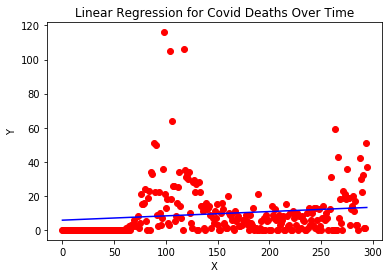

In [23]:
plt.scatter(X,Y,color = 'red')
plt.plot(X,y_pred_d,color = 'blue')
plt.title('Linear Regression for Covid Deaths Over Time')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [24]:
r2_score(Y,y_pred_d)

0.020143754437474293

In [25]:
# Decision tree exported to pdf
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X,Y)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("penn_deaths")

'penn_deaths.pdf'

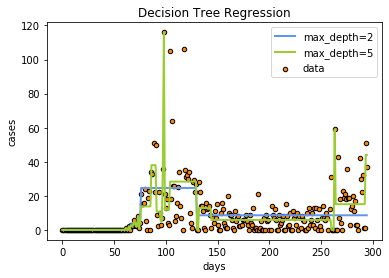

In [26]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, Y)
regr_2.fit(X, Y)
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
plt.figure()
plt.scatter(X, Y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("days")
plt.ylabel("cases")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Identify counties at risk

In [27]:
# from previous analysis, I have determined these five counties to be the most at risk
counties_at_risk = ['Berks County', 'Delaware County', 'Lehigh County', 'Northampton County', 'Philadelphia County']

#### Cases

In [28]:
berks = cases_full.loc[cases_full['County Name'] == counties_at_risk[0]]
berks = berks.iloc[:, 1:]
berks = berks.sum()
berks = berks.astype('int')
delaware = cases_full.loc[cases_full['County Name'] == counties_at_risk[1]]
delaware = delaware.iloc[:, 1:]
delaware = delaware.sum()
delaware = delaware.astype('int')
lehigh = cases_full.loc[cases_full['County Name'] == counties_at_risk[2]]
lehigh = lehigh.iloc[:, 1:]
lehigh = lehigh.sum()
lehigh = lehigh.astype('int')
northampton = cases_full.loc[cases_full['County Name'] == counties_at_risk[3]]
northampton = northampton.iloc[:, 1:]
northampton = northampton.sum()
northampton = northampton.astype('int')
philadelphia = cases_full.loc[cases_full['County Name'] == counties_at_risk[4]]
philadelphia = philadelphia.iloc[:, 1:]
philadelphia = philadelphia.sum()
philadelphia = philadelphia.astype('int')

In [29]:
X_b = reshaped_days_since_first
Y_b = berks.values.reshape(-1, 1)
X_d = reshaped_days_since_first
Y_d = delaware.values.reshape(-1, 1)
X_l = reshaped_days_since_first
Y_l = lehigh.values.reshape(-1, 1)
X_n = reshaped_days_since_first
Y_n = northampton.values.reshape(-1, 1)
X_p = reshaped_days_since_first
Y_p = philadelphia.values.reshape(-1, 1)

In [30]:
regressor_b = LinearRegression()
regressor_b.fit(X_b,Y_b)
regressor_d = LinearRegression()
regressor_d.fit(X_d,Y_d)
regressor_l = LinearRegression()
regressor_l.fit(X_l,Y_l)
regressor_n = LinearRegression()
regressor_n.fit(X_n,Y_n)
regressor_p = LinearRegression()
regressor_p.fit(X_p,Y_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
y_pred_b = regressor_b.predict(X_b)
y_pred_d = regressor_d.predict(X_d)
y_pred_l = regressor_l.predict(X_l)
y_pred_n = regressor_n.predict(X_n)
y_pred_p = regressor_p.predict(X_p)

In [32]:
print(regressor_b.coef_)
print(regressor_b.intercept_)

[[0.04720288]]
[1.74931287]


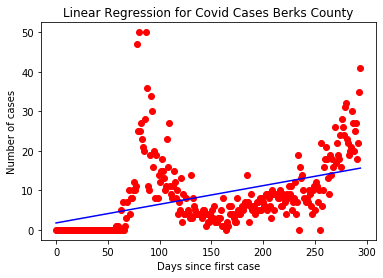

In [33]:
plt.scatter(X_b,Y_b,color = 'red')
plt.plot(X_b,y_pred_b,color = 'blue')
plt.title('Linear Regression for Covid Cases Berks County')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

In [34]:
print(regressor_d.coef_)
print(regressor_d.intercept_)

[[0.03743771]]
[3.8322492]


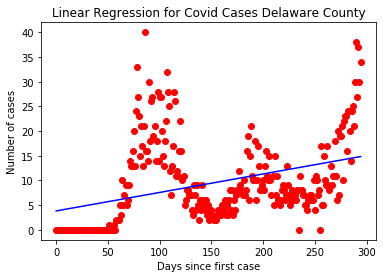

In [35]:
plt.scatter(X_d,Y_d,color = 'red')
plt.plot(X_d,y_pred_d,color = 'blue')
plt.title('Linear Regression for Covid Cases Delaware County')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

In [36]:
print(regressor_l.coef_)
print(regressor_l.intercept_)

[[0.02125796]]
[4.16999542]


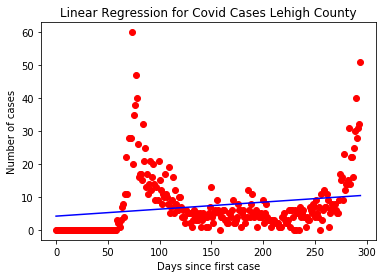

In [37]:
plt.scatter(X_l,Y_l,color = 'red')
plt.plot(X_l,y_pred_l,color = 'blue')
plt.title('Linear Regression for Covid Cases Lehigh County')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

In [38]:
print(regressor_n.coef_)
print(regressor_n.intercept_)

[[0.0206129]]
[4.03092075]


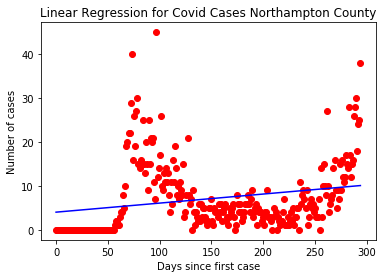

In [39]:
plt.scatter(X_n,Y_n,color = 'red')
plt.plot(X_n,y_pred_n,color = 'blue')
plt.title('Linear Regression for Covid Cases Northampton County')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

In [40]:
print(regressor_p.coef_)
print(regressor_p.intercept_)

[[0.04004506]]
[3.86252863]


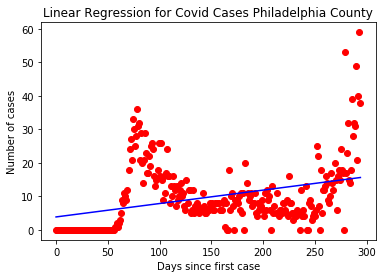

In [41]:
plt.scatter(X_p,Y_p,color = 'red')
plt.plot(X_p,y_pred_p,color = 'blue')
plt.title('Linear Regression for Covid Cases Philadelphia County')
plt.xlabel('Days since first case')
plt.ylabel('Number of cases')
plt.show()

#### Deaths

In [42]:
berks_deaths = deaths_full.loc[cases_full['County Name'] == counties_at_risk[0]]
berks_deaths = berks_deaths.iloc[:, 1:]
berks_deaths = berks_deaths.sum()
berks_deaths = berks_deaths.astype('int')
delaware_deaths = deaths_full.loc[cases_full['County Name'] == counties_at_risk[1]]
delaware_deaths = delaware_deaths.iloc[:, 1:]
delaware_deaths = delaware_deaths.sum()
delaware_deaths = delaware_deaths.astype('int')
lehigh_deaths = deaths_full.loc[cases_full['County Name'] == counties_at_risk[2]]
lehigh_deaths = lehigh_deaths.iloc[:, 1:]
lehigh_deaths = lehigh_deaths.sum()
lehigh_deaths = lehigh_deaths.astype('int')
northampton_deaths = deaths_full.loc[cases_full['County Name'] == counties_at_risk[3]]
northampton_deaths = northampton_deaths.iloc[:, 1:]
northampton_deaths = northampton_deaths.sum()
northampton_deaths = northampton_deaths.astype('int')
philadelphia_deaths = deaths_full.loc[cases_full['County Name'] == counties_at_risk[4]]
philadelphia_deaths = philadelphia_deaths.iloc[:, 1:]
philadelphia_deaths = philadelphia_deaths.sum()
philadelphia_deaths = philadelphia_deaths.astype('int')

In [43]:
X_b_deaths = reshaped_days_since_first
Y_b_deaths = berks_deaths.values.reshape(-1, 1)
X_d_deaths = reshaped_days_since_first
Y_d_deaths = delaware_deaths.values.reshape(-1, 1)
X_l_deaths = reshaped_days_since_first
Y_l_deaths = lehigh_deaths.values.reshape(-1, 1)
X_n_deaths = reshaped_days_since_first
Y_n_deaths = northampton_deaths.values.reshape(-1, 1)
X_p_deaths = reshaped_days_since_first
Y_p_deaths = philadelphia_deaths.values.reshape(-1, 1)

In [44]:
regressor_b_deaths = LinearRegression()
regressor_b_deaths.fit(X_b_deaths,Y_b_deaths)
regressor_d_deaths = LinearRegression()
regressor_d_deaths.fit(X_d_deaths,Y_d_deaths)
regressor_l_deaths = LinearRegression()
regressor_l_deaths.fit(X_l_deaths,Y_l_deaths)
regressor_n_deaths = LinearRegression()
regressor_n_deaths.fit(X_n_deaths,Y_n_deaths)
regressor_p_deaths = LinearRegression()
regressor_p_deaths.fit(X_p_deaths,Y_p_deaths)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
y_pred_b_deaths = regressor_b_deaths.predict(X_b_deaths)
y_pred_d_deaths = regressor_d_deaths.predict(X_d_deaths)
y_pred_l_deaths = regressor_l_deaths.predict(X_l_deaths)
y_pred_n_deaths = regressor_n_deaths.predict(X_n_deaths)
y_pred_p_deaths = regressor_p_deaths.predict(X_p_deaths)

In [46]:
print(regressor_b_deaths.coef_)
print(regressor_b_deaths.intercept_)

[[-0.00107229]]
[0.42881356]


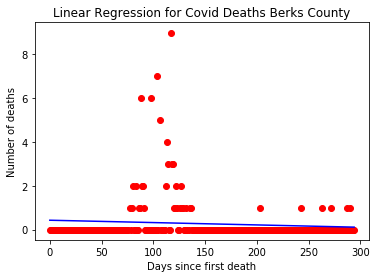

In [47]:
plt.scatter(X_b_deaths,Y_b_deaths,color = 'red')
plt.plot(X_b_deaths,y_pred_b_deaths,color = 'blue')
plt.title('Linear Regression for Covid Deaths Berks County')
plt.xlabel('Days since first death')
plt.ylabel('Number of deaths')
plt.show()

In [48]:
print(regressor_d_deaths.coef_)
print(regressor_d_deaths.intercept_)

[[-0.00167902]]
[0.67732478]


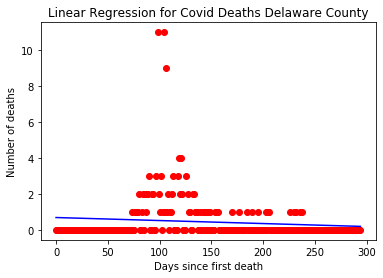

In [49]:
plt.scatter(X_d_deaths,Y_d_deaths,color = 'red')
plt.plot(X_d_deaths,y_pred_d_deaths,color = 'blue')
plt.title('Linear Regression for Covid Deaths Delaware County')
plt.xlabel('Days since first death')
plt.ylabel('Number of deaths')
plt.show()

In [50]:
print(regressor_l_deaths.coef_)
print(regressor_l_deaths.intercept_)

[[-0.00077033]]
[0.45222171]


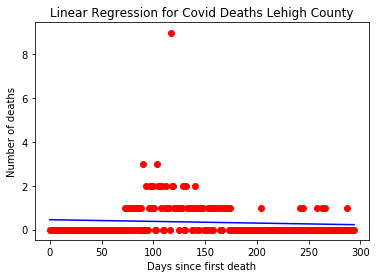

In [51]:
plt.scatter(X_l_deaths,Y_l_deaths,color = 'red')
plt.plot(X_l_deaths,y_pred_l_deaths,color = 'blue')
plt.title('Linear Regression for Covid Deaths Lehigh County')
plt.xlabel('Days since first death')
plt.ylabel('Number of deaths')
plt.show()

In [52]:
print(regressor_n_deaths.coef_)
print(regressor_n_deaths.intercept_)

[[-0.00108959]]
[0.48559322]


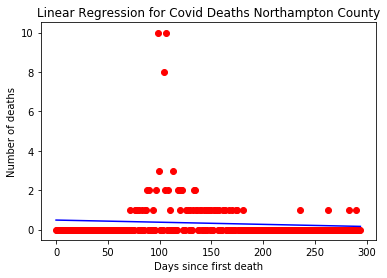

In [53]:
plt.scatter(X_n_deaths,Y_n_deaths,color = 'red')
plt.plot(X_n_deaths,y_pred_n_deaths,color = 'blue')
plt.title('Linear Regression for Covid Deaths Northampton County')
plt.xlabel('Days since first death')
plt.ylabel('Number of deaths')
plt.show()

In [54]:
print(regressor_p_deaths.coef_)
print(regressor_p_deaths.intercept_)

[[-0.00144858]]
[0.57226294]


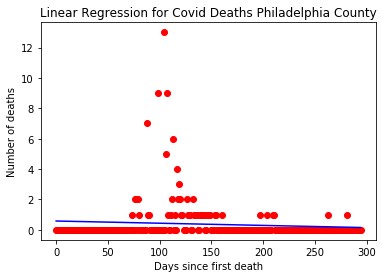

In [55]:
plt.scatter(X_p_deaths,Y_p_deaths,color = 'red')
plt.plot(X_p_deaths,y_pred_p_deaths,color = 'blue')
plt.title('Linear Regression for Covid Deaths Philadelphia County')
plt.xlabel('Days since first death')
plt.ylabel('Number of deaths')
plt.show()

### Point of no return

In [56]:
hosp_data = pd.read_csv(hospital_data, index_col = 0)

In [57]:
hosp_data.sort_values(by = ['deaths'], ascending = False)

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Philadelphia County,30620,1797,1584064,The Liacouras Center Field Hospital (Temporari...,Short Term Acute Care Hospital,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0
Philadelphia County,30620,1797,1584064,Fairmount Behavioral Health System (FKA Fairmo...,Psychiatric Hospital,239.0,172.0,1.0,1.0,0.0,0.876442,67.0,1.0
Philadelphia County,30620,1797,1584064,Pennsylvania Hospital,Short Term Acute Care Hospital,475.0,403.0,50.0,50.0,50.0,0.519460,72.0,16.0
Philadelphia County,30620,1797,1584064,Roxborough Memorial Hospital,Short Term Acute Care Hospital,131.0,107.0,18.0,18.0,0.0,0.302189,24.0,3.0
Philadelphia County,30620,1797,1584064,Haven Behavioral Hospital of Philadelphia,Psychiatric Hospital,67.0,36.0,0.0,0.0,0.0,0.872451,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Clearfield County,292,1,79255,Penn Highlands Clearfield,Short Term Acute Care Hospital,50.0,40.0,7.0,7.0,0.0,0.327123,10.0,2.0
Sullivan County,10,0,6066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cameron County,8,0,4447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# here we can see the total number of deaths for penn so far
hosp_data['deaths'].sum()

103023

In [59]:
# here is the number of staffed beds for the whole state
hosp_data['NUM_STAFFED_BEDS'].sum()

37603.0

The point of no return would be if the daily deaths surpassed the total number of staffed beds

### I have put the decision tree pdfs into a folder located in this same folder

### Spread Rate

In [60]:
hosp_data.sort_values(by = ['deaths'], ascending = False)

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Philadelphia County,30620,1797,1584064,The Liacouras Center Field Hospital (Temporari...,Short Term Acute Care Hospital,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0
Philadelphia County,30620,1797,1584064,Fairmount Behavioral Health System (FKA Fairmo...,Psychiatric Hospital,239.0,172.0,1.0,1.0,0.0,0.876442,67.0,1.0
Philadelphia County,30620,1797,1584064,Pennsylvania Hospital,Short Term Acute Care Hospital,475.0,403.0,50.0,50.0,50.0,0.519460,72.0,16.0
Philadelphia County,30620,1797,1584064,Roxborough Memorial Hospital,Short Term Acute Care Hospital,131.0,107.0,18.0,18.0,0.0,0.302189,24.0,3.0
Philadelphia County,30620,1797,1584064,Haven Behavioral Hospital of Philadelphia,Psychiatric Hospital,67.0,36.0,0.0,0.0,0.0,0.872451,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Clearfield County,292,1,79255,Penn Highlands Clearfield,Short Term Acute Care Hospital,50.0,40.0,7.0,7.0,0.0,0.327123,10.0,2.0
Sullivan County,10,0,6066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cameron County,8,0,4447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
hosp_data.sort_values(by = ['BED_UTILIZATION'])

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Mercer County,662,13,109424,Edgewood Surgical Hospital,Short Term Acute Care Hospital,10.0,10.0,2.0,2.0,0.0,0.029589,0.0,0.0
Wyoming County,72,8,26794,Tyler Memorial Hospital,Short Term Acute Care Hospital,44.0,44.0,6.0,6.0,0.0,0.060959,0.0,2.0
Columbia County,847,35,64964,Berwick Hospital Center,Short Term Acute Care Hospital,90.0,87.0,10.0,10.0,0.0,0.085498,3.0,2.0
Philadelphia County,30620,1797,1584064,Cancer Treatment Centers of America - Philadel...,Short Term Acute Care Hospital,74.0,74.0,12.0,12.0,0.0,0.094150,0.0,2.0
McKean County,51,2,40625,UPMC Kane (FKA Kane Community Hospital),Short Term Acute Care Hospital,31.0,31.0,5.0,5.0,0.0,0.110119,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pike County,559,21,55809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Schuylkill County,1046,52,141359,Geisinger St Lukes Hospital,Short Term Acute Care Hospital,NaN,NaN,32.0,32.0,NaN,NaN,0.0,0.0
Snyder County,236,3,40372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
hosp_data.sort_values(by = ['NUM_STAFFED_BEDS'])

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Philadelphia County,30620,1797,1584064,Wills Eye Hospital,Short Term Acute Care Hospital,4.0,4.0,1.0,1.0,0.0,0.524658,0.0,0.0
Mercer County,662,13,109424,Edgewood Surgical Hospital,Short Term Acute Care Hospital,10.0,10.0,2.0,2.0,0.0,0.029589,0.0,0.0
Allegheny County,11431,341,1216045,AHN McCandless Neighborhood Hospital,Short Term Acute Care Hospital,10.0,10.0,0.0,0.0,NaN,NaN,0.0,0.0
Montgomery County,11738,869,830915,Physicians Care Surgical Hospital,Short Term Acute Care Hospital,12.0,12.0,2.0,2.0,0.0,0.407991,0.0,0.0
Philadelphia County,30620,1797,1584064,Kensington Hospital,Short Term Acute Care Hospital,45.0,14.0,2.0,2.0,0.0,0.699609,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pike County,559,21,55809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Schuylkill County,1046,52,141359,Geisinger St Lukes Hospital,Short Term Acute Care Hospital,NaN,NaN,32.0,32.0,NaN,NaN,0.0,0.0
Snyder County,236,3,40372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
hosp_data.sort_values(by = ['cases'], ascending = False)

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Philadelphia County,30620,1797,1584064,Thomas Jefferson University Hospital,Short Term Acute Care Hospital,908.0,832.0,29.0,29.0,80.0,0.697514,76.0,29.0
Philadelphia County,30620,1797,1584064,Friends Hospital,Psychiatric Hospital,192.0,192.0,1.0,1.0,0.0,0.941881,0.0,1.0
Philadelphia County,30620,1797,1584064,Einstein Medical Center Philadelphia,Short Term Acute Care Hospital,750.0,509.0,32.0,32.0,23.0,0.695143,241.0,17.0
Philadelphia County,30620,1797,1584064,The Liacouras Center Field Hospital (Temporari...,Short Term Acute Care Hospital,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0
Philadelphia County,30620,1797,1584064,Haven Behavioral Hospital of Philadelphia,Psychiatric Hospital,67.0,36.0,0.0,0.0,0.0,0.872451,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fulton County,42,2,14530,Fulton County Medical Center,Critical Access Hospital,21.0,21.0,4.0,4.0,0.0,0.337508,0.0,1.0
Potter County,25,0,16526,UPMC Cole,Critical Access Hospital,49.0,25.0,4.0,4.0,0.0,0.535233,24.0,2.0
Forest County,14,0,7247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
hosp_data.sort_values(by = ['population'], ascending = False)

,cases,deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
County Name,,,,,,,,,,,,,
Philadelphia County,30620,1797,1584064,Corporal Michael J Crescenz VA Medical Center ...,VA Hospital,142.0,142.0,3.0,3.0,NaN,NaN,0.0,2.0
Philadelphia County,30620,1797,1584064,Penn Presbyterian Medical Center,Short Term Acute Care Hospital,350.0,316.0,44.0,44.0,0.0,0.852948,34.0,25.0
Philadelphia County,30620,1797,1584064,Thomas Jefferson University Hospital,Short Term Acute Care Hospital,908.0,832.0,29.0,29.0,80.0,0.697514,76.0,29.0
Philadelphia County,30620,1797,1584064,Einstein Medical Center Philadelphia,Short Term Acute Care Hospital,750.0,509.0,32.0,32.0,23.0,0.695143,241.0,17.0
Philadelphia County,30620,1797,1584064,Kensington Hospital,Short Term Acute Care Hospital,45.0,14.0,2.0,2.0,0.0,0.699609,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Potter County,25,0,16526,UPMC Cole,Critical Access Hospital,49.0,25.0,4.0,4.0,0.0,0.535233,24.0,2.0
Fulton County,42,2,14530,Fulton County Medical Center,Critical Access Hospital,21.0,21.0,4.0,4.0,0.0,0.337508,0.0,1.0
Forest County,14,0,7247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The top 5 things we should take into account with the hospital enrichment are the total population by county, the total cases, the number of staffed beds, the number of liscenced beds and the total number of deaths. As we can see from the data, there are more cases and deaths in high population areas as well as the surrounding areas of those counties. I predict that the spread will be in a circular fashion; starting in high population areas and spreading out in rings around the county. This is shown as the further you get away from the county in question the less cases you will see. It will be like a ripple effect.

### Task 2: For each of the analysis plot

#### trend line

All of the aforementioned analysis have trendlines

#### confidence intervals

All of the aforementioned analysis have confidence intervals displayed below the graphs

#### prediction path
